# Course 4: Planning
## Part 3: Polynomial Trajectory Generation
#### By Jonathan L. Moran (jonathan.moran107@gmail.com)
From the Self-Driving Car Engineer Nanodegree programme offered at Udacity.

## Objectives

* Write a polynomial trajectory generator in Python;
* Test the polynomial trajectory generator on two simulated vehicles;
* Weight the provided cost functions appropriately so the behaviour of the test vehicle is ideal.

## 1. Introduction

In [1]:
### Importing the required modules

In [27]:
from math import exp, sqrt
from matplotlib import pyplot as plt
import numpy as np
import random
import sys
from typing import Callable, List, Tuple, TypedDict, Union

## 2. Programming Task

### 2.1. Polynomial Trajectory Generation in Python

#### Hyperparameters / constants

In [3]:
### Setting the environment variables

In [4]:
N_SAMPLES = 10
# Maximum speed limit (enforced for ego-vehicle)
SPEED_LIMIT = 30
# Radius of vehicle perimetre,
# modelled as a circle to simplify collision detection 
VEHICLE_RADIUS = 1.5            # metres (m)

In [5]:
### Setting the ego-vehicle trajectory variables

In [6]:
# Longitudinal distance kinematic state vector
# i.e., $[s, \dot{s}, \ddot{s}]$
SIGMA_S = [10.0, 4.0, 2.0]
# Lateral distance kinematic state vector
# i.e., $[d, \dot{d}, \ddot{d}]$
SIGMA_D = [1.0, 1.0, 1.0]
# Total elapsed time to complete manoeuvre
SIGMA_T = 2.0

In [7]:
### Setting the vehicle kinematics (all actors)

In [8]:
# Maximum jerk and acceleration
MAX_JERK = 10                   # m/s^3
MAX_ACCEL = 10                  # m/s^2

# Expected maximum jerk and acceleration allowed in one-second interval
EXPECTED_JERK_IN_ONE_SEC = 2    # m/s^3
EXPECTED_ACC_IN_ONE_SEC = 1     # m/s^2

#### `Vehicle` actor class

Below we define the `Vehicle` actor, i.e., a class with an assigned `start_state`. This `start_state` is a list of coefficients describing the vehicle boundary conditions at time $t = 0$. Therefore, `start_state` represents the following:

$$
\begin{align}
\texttt{start_state} = \left[s, \ \dot{s}, \ \ddot{s}, \ d, \ \dot{d}, \ \ddot{d}\right].
\end{align}
$$

The member function `state_in` computes the kinematics state vector for the given time-step `t`, and returns the `state` corresponding to the 1D kinematics evaluated with respect to the starting boundary conditions.    

In [9]:
### From J. Moran's `helpers.py`

In [11]:
class Vehicle(object):
    """Defines the vehicle actor.
    
    Note: Non-ego vehicle move with constant acceleration.
    """
    
    def __init__(self, 
            start: List[float]
    ):
        """Initialises a `Vehicle` instance with `start` state.
        
        Here `state` is the starting kinematics state vector which has
        the form: $[s, \dot{s}, \ddot{s}, d, \dot{d}, \ddot{d}]$.
        
        :param start: Vehicle starting kinematics state vector.
        """
        
        self.start_state = start
    
    def state_in(self, 
            t: float
    ) -> List[float]:
        """Returns the kinematics state vector for the given time-step.
        
        Here the returned `state` vector is the evaluated 1D kinematics
        equations for longitudinal / lateral position along $s$- and $d$-axis
        for the given time-step `t`.
        
        :param t: Time-step of the vehicle to evaluate kinematics w.r.t. 
        :return state: Kinematics state vector of the vehicle at time-step `t`.
        """
        
        s = self.start_state[:3]
        d = self.start_state[3:]
        state = [
            s[0] + (s[1] * t) + s[2] * t**2 / 2.0,
            s[1] + s[2] * t,
            s[2],
            d[0] + (d[1] * t) + d[2] * t**2 / 2.0,
            d[1] + d[2] * t,
            d[2],
        ]
        return state

In [13]:
### For typing hints
Vehicles = TypedDict('Vehicles', v_id = int, vehicle = Vehicle)

Note that in the cost functions below, `traj` is the single trajectory to evaluate the cost with respect to. Each `traj` is a `tuple` with three elements: the list of coefficients of the quintic polynomial describing $s(t)$ — the longitudinal motion of the trajectory, the list of coefficients of the quintic polynomial describing $d(t)$ — the lateral motion of the trajectory, and a `float` describing the total elapsed time (in seconds) the trajectory should be executed for in order to reach the goal state. This elapsed time is defined with respect to the assumed current time $t = 0$.

In [14]:
### From J. Moran's `helpers.py`

In [20]:
def logistic(
        x: float
) -> float:
    """Computes the sigmoid function.
    
    A function that returns a value between 0 and 1 for `x` in the 
    range [0, infinity] and -1 to 1 for x in the range [-infinity, infinity].

    :param x: Value to evaluate the sigmoid function at.
    :returns: Value computed by the sigmoid function.
    """
    
    return 2.0 / (1 + exp(-x)) - 1.0


def to_equation(
        coefficients: List[float]
) -> Callable[[float], float]:
    """Returns a polynomial function with the given `coefficients`.
    
    :param coefficients: Set of coefficient values to use in the polynomial.
    """
    
    def f(t):
        '''Returns a polynomial function w.r.t. time `t`.'''
        total = 0.0
        for i, c in enumerate(coefficients):
            total += c * t ** i
        return total
    return f


def differentiate(
        coefficients: List[float]
) -> List[float]:
    """Returns the coefficients of the derivative of the polynomial.
    
    :param coefficients: Set of coefficient values of the polynomial.
    :returns: new_cos, Set of coefficients of the differentiated polynomial.
    """
    
    new_cos = []
    for deg, prev_co in enumerate(coefficients[1:]):
        new_cos.append((deg + 1) * prev_co)
    return new_cos


def nearest_approach_to_any_vehicle(
        traj: Tuple[List[float], List[float], float],
        vehicles: Vehicles
) -> float:
    """Returns the closest distance to any vehicle during the given trajectory.
    
    :param traj: Trajectory to evaluate.
    :param vehicles: Dict of `Vehicle` instances to consider the distance to.
    :returns: closest, Distance to the closest vehicle from this trajectory.
    """
    
    closest = sys.maxsize
    for v in vehicles.values():
        d = nearest_approach(traj, v)
        if d < closest:
            closest = d
    return closest


def nearest_approach(
        traj: Tuple[List[float], List[float], float], 
        vehicle: Vehicle
) -> float:
    """Returns the closest distance from ego to given vehicle during the trajectory.
    
    Here the distance to the `vehicle` from the ego is considered at all time-steps
    in the trajectory. The closest distance from which the ego gets to the `vehicle`
    is returned. 
    
    :param traj: Trajectory to evaluate.
    :param vehicle: Single `Vehicle` to consider the distance to.
    :returns: closest, Distance closest to the `vehicle` from this trajectory.
    """
    
    closest = sys.maxsize
    s_,d_,T = traj
    s = to_equation(s_)
    d = to_equation(d_)
    for i in range(100):
        t = float(i) / 100 * T
        cur_s = s(t)
        cur_d = d(t)
        targ_s, _, _, targ_d, _, _ = vehicle.state_in(t)
        dist = sqrt((cur_s-targ_s)**2 + (cur_d-targ_d)**2)
        if dist < closest:
            closest = dist
    return closest


def show_trajectory(
        s_coeffs: List[float],
        d_coeffs: List[float], 
        T: float,
        vehicle: Vehicle=None
):
    """Displays the trajectory over time on a Matplotlib figure.
    
    :param s_coeffs: Coefficients of polynomial along the longitudinal distance axis.
    :param d_coeffs: Coefficients of the polynomial along the lateral distance axis.
    :param T: Total elapsed time (s) starting from $t = 0$.
    :param vehicle: optional, Vehicle to render on the plot.
    """
    
    s = to_equation(s_coeffs)
    d = to_equation(d_coeffs)
    X = []
    Y = []
    if vehicle:
        X2 = []
        Y2 = []
    t = 0
    while t <= T + 0.01:
        X.append(s(t))
        Y.append(d(t))
        if vehicle:
            s_, _, _, d_, _, _ = vehicle.state_in(t)
            X2.append(s_)
            Y2.append(d_)
        t += 0.25
    plt.scatter(X, Y, color="blue")
    if vehicle:
        plt.scatter(X2, Y2, color="red")
    plt.show()

    
def get_f_and_N_derivatives(
        coeffs, 
        N=3
):
    """Computes `N`th derivative of the polynomial formed by `coeffs`.
    
    :param coeffs: Coefficient values of the polynomial.
    :param N: Number of times to differentiate the polynomial.
    :returns: functions, coefficients of the polynomial for each differentiation step. 
    """
    
    functions = [to_equation(coeffs)]
    for i in range(N):
        coeffs = differentiate(coeffs)
        functions.append(to_equation(coeffs))
    return functions

#### Cost functions

The following is a set of cost functions evaluating a variety of cases that arise during a typical highway driving scenario. Here we penalise trajectories which, for example, have at any point during their execution, a distance assumed to be within twice the radius of any neighbouring vehicles. On the other hand, we reward trajectories which, for example, have an average speed or elapsed time-to-goal that are close to their respective target values.

Note that this is not a comprehensive list of all cost functions that should be considered in the real-world; here we neglect to consider scenarios such as merges, intersections, unexpected emergencies or road hazards, etc. We also omit the implementation of two of the provided cost functions — `stays_on_road_cost` and `exceeds speed limit_cost`, for now. 

In [21]:
### From J. Moran's `cost_functions.py`

In [22]:
def time_diff_cost(
        traj: Tuple[List[float], List[float], float],
        target_vehicle: int,
        delta: List[float],
        T: float,
        predictions: Vehicles
) -> float:
    """Evaluates the time-difference cost function.
    
    Penalises trajectories that span a duration which is longer or 
    shorter than the duration requested.
    
    :param traj: Trajectory to evaluate.
    :param target_vehicle: Integer id of target vehicle state (not used).
    :param delta: List of offset values between ego- and `target_vehicle`.
    :param T: Total elapsed time (s) starting from $t = 0$.
    :param predictions: Dict of estimated vehicle trajectories. 
    :returns: Cost function evaluated for the given time-difference. 
    """
    
    _, _, t = traj
    return logistic(float(abs(t - T)) / T)


def s_diff_cost(
        traj: Tuple[List[float], List[float], float],
        target_vehicle: int,
        delta: List[float],
        T: float,
        predictions: Vehicles
) -> float:
    """Evaluates the longitudinal distance difference cost function.
    
    Penalises trajectories whose longitudinal distance, i.e., $s$-coordinate
    and its derivatives, differ from the goal. 
    
    :param traj: Trajectory to evaluate.
    :param target_vehicle: Target vehicle id from `predictions` to fetch the state of.
    :param delta: List of offset values between ego- and `target_vehicle`.
    :param T: Total elapsed time (s) starting from $t = 0$.
    :param predictions: Dict of estimated vehicle trajectories.
    :returns: Cost function evaluated for the given longitudinal distance difference. 
    """
    
    s, _, T = traj
    target = predictions[target_vehicle].state_in(T)
    target = list(np.array(target) + np.array(delta))
    s_targ = target[:3]
    S = [f(T) for f in get_f_and_N_derivatives(s, 2)]
    cost = 0
    for actual, expected, sigma in zip(S, s_targ, SIGMA_S):
        diff = float(abs(actual - expected))
        cost += logistic(diff / sigma)
    return cost


def d_diff_cost(
        traj: Tuple[List[float], List[float], float],
        target_vehicle: int,
        delta: List[float],
        T: float,
        predictions: Vehicles
) -> float:
    """Evaluates the lateral distance difference cost function.
    
    Penalises trajectories whose lateral distance, i.e., $d$-coordinate
    and its derivatives, differ from the goal. 
    
    :param traj: Trajectory to evaluate.
    :param target_vehicle: Target vehicle id from `predictions` to fetch the state of.
    :param delta: List of offset values between ego- and `target_vehicle`.
    :param T: Total elapsed time (s) starting from $t = 0$.
    :param predictions: Dict of estimated vehicle trajectories.
    :returns: Cost function evaluated for the given lateral distance difference. 
    """
    
    _, d_coeffs, T = traj
    d_dot_coeffs = differentiate(d_coeffs)
    d_ddot_coeffs = differentiate(d_dot_coeffs)
    d = to_equation(d_coeffs)
    d_dot = to_equation(d_dot_coeffs)
    d_ddot = to_equation(d_ddot_coeffs)
    D = [d(T), d_dot(T), d_ddot(T)]
    target = predictions[target_vehicle].state_in(T)
    target = list(np.array(target) + np.array(delta))
    d_targ = target[3:]
    cost = 0
    for actual, expected, sigma in zip(D, d_targ, SIGMA_D):
        diff = float(abs(actual - expected))
        cost += logistic(diff / sigma)
    return cost


def collision_cost(
        traj: Tuple[List[float], List[float], float],
        target_vehicle: int,
        delta: List[float],
        T: float,
        predictions: Vehicles
) -> float:
    """Evaluates the collision cost function.
    
    Binary cost function which penalises an imminent collision.
    Returns `1.0` if ego-vehicle is within distance less than twice
    the radius of a neighbouring vehicle, otherwise `0.0`.
    
    :param traj: Trajectory to evaluate.
    :param target_vehicle: Target vehicle id from `predictions` to fetch the state of.
    :param delta: List of offset values between ego- and `target_vehicle`.
    :param T: Total elapsed time (s) starting from $t = 0$.
    :param predictions: Dict of estimated vehicle trajectories.
    :returns: Binary collision cost evaluated for the given trajectory.     
    """
    
    nearest = nearest_approach_to_any_vehicle(traj, predictions)
    if nearest < 2 * VEHICLE_RADIUS:
        return 1.0
    else:
        return 0.0

    
def buffer_cost(
        traj: Tuple[List[float], List[float], float],
        target_vehicle: int,
        delta: List[float],
        T: float,
        predictions: Vehicles
) -> float:
    """Evaluates the buffer cost function.
    
    Penalises trajectories which closely approach other vehicles.
    
    :param traj: Trajectory to evaluate.
    :param target_vehicle: Target vehicle id from `predictions` to fetch the state of.
    :param delta: List of offset values between ego- and `target_vehicle`.
    :param T: Total elapsed time (s) starting from $t = 0$.
    :param predictions: Dict of estimated vehicle trajectories.
    :returns: Binary collision cost evaluated for the given trajectory.     
    """
    nearest = nearest_approach_to_any_vehicle(traj, predictions)
    return logistic(2 * VEHICLE_RADIUS / nearest)


def stays_on_road_cost(
        traj: Tuple[List[float], List[float], float],
        target_vehicle: int,
        delta: List[float],
        T: float,
        predictions: Vehicles
) -> float:
    """Evaluates the road boundary cost function.
    
    NOTE: NOT YET IMPLEMENTED.
    """
    pass


def exceeds_speed_limit_cost(
        traj: Tuple[List[float], List[float], float],
        target_vehicle: int,
        delta: List[float],
        T: float,
        predictions: Vehicles
) -> float:
    """Evaluates the maximum speed cost function.
    
    NOTE: NOT YET IMPLEMENTED.
    """
    pass


def efficiency_cost(
        traj: Tuple[List[float], List[float], float],
        target_vehicle: int,
        delta: List[float],
        T: float,
        predictions: Vehicles
) -> float:
    """Evaluates the efficiency cost function.
    
    Rewards trajectories whose average speed closely matches target speed.
    
    :param traj: Trajectory to evaluate.
    :param target_vehicle: Target vehicle id from `predictions` to fetch the state of.
    :param delta: List of offset values between ego- and `target_vehicle`.
    :param T: Total elapsed time (s) starting from $t = 0$.
    :param predictions: Dict of estimated vehicle trajectories.
    :returns: Efficiency cost evaluated for the given trajectory.  
    """
    
    s, _, t = traj
    s = to_equation(s)
    avg_v = float(s(t)) / t
    targ_s, _, _, _, _, _ = predictions[target_vehicle].state_in(t)
    targ_v = float(targ_s) / t
    return logistic(2 * float(targ_v - avg_v) / avg_v)


def total_accel_cost(
        traj: Tuple[List[float], List[float], float],
        target_vehicle: int,
        delta: List[float],
        T: float,
        predictions: Vehicles
) -> float:
    """Evaluates the total acceleration cost function.
    
    Penalises trajectories with acceleration above the expected
    one-second acceleration value (`EXPECTED_ACC_IN_ONE_SEC`).
    
    :param traj: Trajectory to evaluate.
    :param target_vehicle: Target vehicle id from `predictions` to fetch the state of.
    :param delta: List of offset values between ego- and `target_vehicle`.
    :param T: Total elapsed time (s) starting from $t = 0$.
    :param predictions: Dict of estimated vehicle trajectories.
    :returns: Acceleration cost evaluated for the given trajectory. 
    """
    
    s, d, t = traj
    s_dot = differentiate(s)
    s_d_dot = differentiate(s_dot)
    a = to_equation(s_d_dot)
    total_acc = 0
    dt = float(T) / 100.0
    for i in range(100):
        t = dt * i
        acc = a(t)
        total_acc += abs(acc * dt)
    acc_per_second = total_acc / T
    return logistic(acc_per_second / EXPECTED_ACC_IN_ONE_SEC)


def total_jerk_cost(
        traj: Tuple[List[float], List[float], float],
        target_vehicle: int,
        delta: List[float],
        T: float,
        predictions: Vehicles
) -> float:
    """Evalautes the total jerk cost function.
    
    Penalises trajectories with jerk above the expected
    one-second jerk value (`EXPECTED_JERK_IN_ONE_SEC`).
    
    :param traj: Trajectory to evaluate.
    :param target_vehicle: Target vehicle id from `predictions` to fetch the state of.
    :param delta: List of offset values between ego- and `target_vehicle`.
    :param T: Total elapsed time (s) starting from $t = 0$.
    :param predictions: Dict of estimated vehicle trajectories.
    :returns: Total jerk binary cost evaluated for the given trajectory. 
    """
    
    s, d, t = traj
    s_dot = differentiate(s)
    s_d_dot = differentiate(s_dot)
    jerk = to_equation(differentiate(s_d_dot))
    total_jerk = 0
    dt = float(T) / 100.0
    for i in range(100):
        t = dt * i
        j = jerk(t)
        total_jerk += abs(j * dt)
    jerk_per_second = total_jerk / T
    return logistic(jerk_per_second / EXPECTED_JERK_IN_ONE_SEC)


def max_accel_cost(
        traj: Tuple[List[float], List[float], float],
        target_vehicle: int,
        delta: List[float],
        T: float,
        predictions: Vehicles
) -> float:
    """Evaluates the maximum acceleration cost function.
    
    Binary cost penalising trajectories whose acceleration exceeds the
    maximum allowed acceleration (`MAX_ACCEL`).
    
    :param traj: Trajectory to evaluate.
    :param target_vehicle: Target vehicle id from `predictions` to fetch the state of.
    :param delta: List of offset values between ego- and `target_vehicle`.
    :param T: Total elapsed time (s) starting from $t = 0$.
    :param predictions: Dict of estimated vehicle trajectories.
    :returns: Maximum accleration binary cost evaluated for the given trajectory. 
    """
    
    s, d, t = traj
    s_dot = differentiate(s)
    s_d_dot = differentiate(s_dot)
    a = to_equation(s_d_dot)
    all_accs = [a(float(T) / 100 * i) for i in range(100)]
    max_acc = max(all_accs, key=abs)
    if abs(max_acc) > MAX_ACCEL:
        return 1
    else:
        return 0
    

def max_jerk_cost(
        traj: Tuple[List[float], List[float], float],
        target_vehicle: int,
        delta: List[float],
        T: float,
        predictions: Vehicles
) -> float:
    """Evaluates the maximum jerk cost function.
    
    Binary cost penalising trajectories whose jerk exceeds the
    maximum allowed jerk (`MAX_JERK`).

    :param traj: Trajectory to evaluate.
    :param target_vehicle: Target vehicle id from `predictions` to fetch the state of.
    :param delta: List of offset values between ego- and `target_vehicle`.
    :param T: Total elapsed time (s) starting from $t = 0$.
    :param predictions: Dict of estimated vehicle trajectories.
    :returns: Maximum jerk binary cost evaluated for the given trajectory. 
    """
    
    s, d, t = traj
    s_dot = differentiate(s)
    s_d_dot = differentiate(s_dot)
    jerk = differentiate(s_d_dot)
    jerk = to_equation(jerk)
    all_jerks = [jerk(float(T) / 100 * i) for i in range(100)]
    max_jerk = max(all_jerks, key=abs)
    if abs(max_jerk) > MAX_JERK:
        return 1
    else:
        return 0

#### Cost function weights

Assigned below are the weight values multiplied to their respective returned cost function values for each given trajectory to consider. The weighted sum of the cost function returns will be calculated, and the trajectory whose total weighted sum is minimal will be selected for execution by the ego-vehicle.

In [23]:
### TODO: Adjust weights assigned to the existing cost functions

In [24]:
WEIGHTED_COST_FUNCTIONS = [
    (time_diff_cost,    1),
    (s_diff_cost,       1),
    (d_diff_cost,       1),
    (efficiency_cost,   1),
    (max_jerk_cost,     1),
    (total_jerk_cost,   1),
    (collision_cost,    1),
    (buffer_cost,       1),
    (max_accel_cost,    1),
    (total_accel_cost,  1),
]

#### Polynomial Trajectory Generator

Below we implement the Polynomial Trajectory Generator programme.

The `PTG` function finds the best trajectory by computing the minimum weighted cost over all possible trajectory perturbations. Each trajectory from the start to goal state is described by a set of two quintic polynomials parameterised by the coefficients of the boundary conditions `start_s`, `start_d`. These starting kinematic state vectors are used along with the derived minimised-jerk trajectory equation to compute the trajectories in 1D with respect to the total elapsed time `T` to the goal state. 

Each quintic polynomial describes the motion of the ego-vehicle along either the longitudinal $s$-axis or lateral $d$-axis (using the [Frenet](https://fjp.at/posts/optimal-frenet/) coordinate frame). The trajectory, a tuple of

$$
\begin{align}
\texttt{traj = (s_coefficients, d_coefficients, t)},
\end{align}
$$

describe the estimated jerk-minimum trajectory to the goal. The resulting quintic polynomials belonging to the trajectory are perturbed (deviated) using the [`random.gauss`](https://docs.python.org/3/library/random.html#random.gauss) floating-point number generator. Here we parameterise the Gaussian to sample from using the original coefficients of the quintic polynomials of either $s(t)$ or $d(t)$ as the `mean` parameter, and the `sigma` parameter is given as the pre-defined constant `SIGMA_S` or `SIGMA_D`, respectively.

From these set of perturbed trajectories we select the cost-minimal to execute. In other words, we run each trajectory through the set of cost functions weighted by the values given in `WEIGHTED_COST_FUNCTIONS`, then return the single trajectory with the lowest weighted-sum cost score.  

In [28]:
#from cost_functions import *
#from constants import *


def PTG(
        start_s: List[float],
        start_d: List[float],
        target_vehicle: int,
        delta: List[int],
        T: float,
        predictions: Vehicles
) -> Tuple[List[float], List[float], float]:
    """Finds the best trajectory according to `WEIGHTED_COST_FUNCTIONS`.

    :param start_s: Starting longitudinal motion state vector,
        i.e., list of `[s, s_dot, s_ddot]` values.
    :param start_d: Starting lateral motion state vector,
        i.e., list of `[d, d_dot, d_ddot]` values.
    :param target_vehicle: integer id of the leading vehicle which trajectories
        are set relative to, used to retrieve the state from `predictions` dict.
    :param delta: list of goal offset values between ego- and `target_vehicle`,
        e.g., for `t=5`, we have `target_vehicle` at `[100, 10, 0, 0, 0, 0]` and
        `delta` of `[-10, 0, 0, 4, 0, 0]`, then our goal state at `t=5` will be
        `[90, 10, 0, 4, 0, 0]`. In other words, we describe the following goal:
        "follow 10 metres behind and 4 metres to the right of `target_vehicle`."
    :param T: Total elapsed time at which the ego-vehicle will reach the goal,
        relative to the current time-step assumed to be $t = 0$.
    :param predictions: dict of `{v_id : vehicle}` instances. Each `Vehicle`
        has method `vehicle.state_in(t)` which returns the expected kinematics,
        i.e., `[s, s_dot, s_ddot, d, d_dot, d_ddot]`, at time `t`.
    :returns: `(best_s, best_d, best_t)`, tuple of trajectory values s.t. `best_s`
        and `best_d` are the quintic polynomial coefficient vectors of $s(t)$, $d(t)$,
        respectively, and `best_t` is the elapsed time associated with the trajectory.
    """
    
    # Get the target `Vehicle` state
    target = predictions[target_vehicle]
    # Generate alternative goal states
    all_goals = []
    timestep = 0.5
    t = T - 4 * timestep
    while t <= T + 4 * timestep:
        target_state = np.array(target.state_in(t)) + np.array(delta)
        goal_s = target_state[:3]
        goal_d = target_state[3:]
        goals = [(goal_s, goal_d, t)]
        for _ in range(N_SAMPLES):
            perturbed = perturb_goal(goal_s, goal_d)
            goals.append((perturbed[0], perturbed[1], t))
        all_goals += goals
        t += timestep
    # Find the best trajectory with minimised weighted cost
    trajectories = []
    for goal in all_goals:
        s_goal, d_goal, t = goal
        s_coefficients = JMT(start_s, s_goal, t)
        d_coefficients = JMT(start_d, d_goal, t)
        trajectories.append(tuple([s_coefficients, d_coefficients, t]))
    best = min(
        trajectories, 
        key=lambda tr: calculate_cost(
            tr, target_vehicle, delta, T, predictions, WEIGHTED_COST_FUNCTIONS
        )
    )
    # Compute the weighted cost of the best trajectory found
    calculate_cost(
        best, 
        target_vehicle, 
        delta, 
        T, 
        predictions, 
        WEIGHTED_COST_FUNCTIONS, 
        verbose=True
    )
    return best


def calculate_cost(
        trajectory: Tuple[List[float], List[float], float],
        target_vehicle: int, 
        delta: List[float],
        goal_t: float,
        predictions: Vehicles,
        cost_functions_with_weights: List[Union[
            Callable[[Vehicle, int, float, float, Vehicles], float],
            float
        ]],
        verbose=False
) -> float:
    """Computes the weighted cost of the given cost functions.
    
    :param trajectory: Trajectory to compute the cost relative to.
    :param target_vehicle: Target vehicle id to fetch the state of.
    :param delta: List of offset values between ego- and `target_vehicle`.
    :param goal_t: Total elapsed execution time (s) to complete the trajectory.
    :param predictions: Dict of estimated vehicle trajectories.
    :returns: Maximum jerk binary cost evaluated for the given trajectory. 
    """
    
    cost = 0.0
    for cf, weight in cost_functions_with_weights:
        new_cost = weight * cf(trajectory, target_vehicle, delta, goal_t, predictions)
        cost += new_cost
        if verbose:
            print(f"cost for {cf.__name__} is \t {new_cost}")
    return cost


def perturb_goal(
        goal_s: np.ndarray,
        goal_d: np.ndarray
) -> Tuple[List[float], List[float]]:
    """Returns a perturbed version of the goal state.
    """
    
    new_s_goal = []
    for mu, sig in zip(goal_s, SIGMA_S):
        new_s_goal.append(random.gauss(mu, sig))
    new_d_goal = []
    for mu, sig in zip(goal_d, SIGMA_D):
        new_d_goal.append(random.gauss(mu, sig))
    return tuple([new_s_goal, new_d_goal])


def JMT(
        start: List[float],
        end: List[float],
        T: float
) -> np.ndarray:
    """Computes the jerk-minimising trajectory from the `start` to `end` states.
    
    :param start: Starting state vector to compute the trajectory from.
    :param end: Final state vector to compute the trajectory to.
    :param T: Total elapsed time to perform the trajectory relative to current $t = 0$.
    :returns alphas: Set of coefficients $\alpha_{0}$ through $\alpha_{5}$ belonging to
        the quintic polynomial of the minimised-jerk trajectory. 
    """
    
    ### Get the first three known coefficients
    a_0, a_1, a_2 = start[0], start[1], start[2] / 2.0
    ### Compute the integration constants
    c_0 = a_0 + a_1 * T + a_2 * T**2
    c_1 = a_1 + 2* a_2 * T
    c_2 = 2 * a_2
    ### Form the matrix equation
    A = np.array([
        [T**3, T**4, T**5],
        [3 * T**2, 4 * T**3, 5 * T**4],
        [6 * T, 12 * T**2, 20 * T**3],
    ])
    B = np.array([
        end[0] - c_0,
        end[1] - c_1,
        end[2] - c_2
    ])
    ### Solve the matrix equation
    a_3_4_5 = np.linalg.solve(A, B)
    ### Append the last three computed coefficients to the first three knowns
    alphas = np.concatenate([
        np.array([a_0, a_1, a_2]), 
        a_3_4_5
    ])
    return alphas

#### Evaluating the Polynomial Trajectory Generator

In [29]:
def evaluate_PTG(
    start_s: List[float],
    start_d: List[float],
    target_vehicle: int,
    delta: List[float],
    T: float, 
    predictions: Vehicles
):
    """Evaluates the Polynomial Trajectory Generator programme.
    
    :param start_s: Starting longitudinal motion state vector,
        i.e., list of `[s, s_dot, s_ddot]` values.
    :param start_d: Starting lateral motion state vector,
        i.e., list of `[d, d_dot, d_ddot]` values.
    :param target_vehicle: integer id of the leading vehicle which trajectories
        are set relative to, used to retrieve the state from `predictions` dict.
    :param delta: list of goal offset values between ego- and `target_vehicle`,
        e.g., for `t=5`, we have `target_vehicle` at `[100, 10, 0, 0, 0, 0]` and
        `delta` of `[-10, 0, 0, 4, 0, 0]`, then our goal state at `t=5` will be
        `[90, 10, 0, 4, 0, 0]`. In other words, we describe the following goal:
        "follow 10 metres behind and 4 metres to the right of `target_vehicle`."
    :param T: Total elapsed time at which the ego-vehicle will reach the goal,
        relative to the current time-step assumed to be $t = 0$.
    :param predictions: dict of `{v_id : vehicle}` instances. Each `Vehicle`
        has method `vehicle.state_in(t)` which returns the expected kinematics,
        i.e., `[s, s_dot, s_ddot, d, d_dot, d_ddot]`, at time `t`.
    """
    
    ### Compute the best (cost-minimal) trajectory
    best = PTG(
        start_s, 
        start_d, 
        target_vehicle, 
        delta, 
        T, 
        predictions
    )
    ### Display the best trajectory in a Matplotlib figure
    show_trajectory(best[0], best[1], best[2], vehicle)

##### Experiment 1: Move ego- to target-vehicle lane

In this first experiment, we request a trajectory which moves our ego-vehicle (in blue) to the lane of the other vehicle (in red). 

Note that we will *not* be adjusting the weight values of the cost functions, nor implementing the other two cost functions at this time.

First, we select a starting state for the ego-vehicle given by the following kinematics values:

In [43]:
### Initial 1D kinematics state vectors in Frenet coordinate frame
# Boundary conditions along the longitudinal $s$-axis
# i.e., $[s, \dot{s}, \ddot{s}]$
start_s = [10, 10, 0]
# Boundary conditions along the lateral $d$-axis
# i.e., $[d, \dot{d}, \ddot{d}]$
start_d = [4, 0, 0]

Then, we define the initial non-ego vehicle $state$ vector
$$
\begin{align}
state = \left[s, \ \dot{s}, \ \ddot{s}, \ d, \ \dot{d}, \ \ddot{d}\right],
\end{align}
$$
i.e., the boundary conditions, to be:

In [44]:
### Non-ego vehicle instance (with initial boundary conditions)
vehicle = Vehicle([0, 10, 0, 0, 0, 0])

which, in other words, means that the non-ego vehicle starts at a position $(s, d) = (0, 0) \ m$, with a starting velocity $(\dot{s}, \dot{d}) = (10, 0) \  m/s$, and an acceleration $(\ddot{s}, \ddot{d}) = (0, 0) \ m/s^2$.

In [45]:
### Set of non-ego vehicle actors 
target = 0                          # id of the non-ego actor in `predictions`
predictions = {target: vehicle}

Now, we define the variables of our intended ego-vehicle trajectory. Here, we set the `delta` kinematics state vector which is the desired offset of the ego-vehicle from the final ending non-ego vehicle state:

In [46]:
### Starting state variables
# List of offset values between ego- and `target_vehicle`
delta = [0, 0, 0, 0, 0, 0]
# Elapsed time to complete manoeuvre
T = 5.0                    # seconds

The `delta` vector will be added to the non-ego vehicle's final `end` state vector to define the ego-vehicle's desired final end state. In other words, we want to create a trajectory with desired execution time `T` that will bring our ego-vehicle to a `final` position given by `final = end + delta`, where `end` is the ending state of the non-ego vehicle after `T` seconds as given by the 1D kinematics.

In this experiment, with a `delta` of all zeros, we are essentially seeking a trajectory that will bring the ego-vehicle (shown in blue below) to the exact ending position of the non-ego vehicle (in red).

In [47]:
### Run the Polynomial Trajectory Generator programme with starting variables

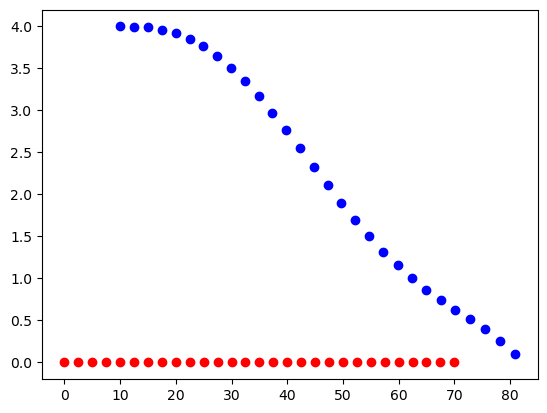

In [48]:
evaluate_PTG(
    start_s,
    start_d,
    target,
    delta,
    T,
    predictions
)

In the experiment results above we see that the ego-vehicle (blue) fails to properly execute the intended manoeuvre — and rightfully so. While we indicated a desired final ego-vehicle state positioned exactly at the ending state of the non-ego vehicle, our weighted cost function analysis surfaced a trajectory from the list of perturbations that resulted in an execution of the ego-vehicle near the desired position *without* incurring a collision.

However, since the cost function weights were assumed to be uniformly set to a value `1.0`, a preference was not given to any of the floating point-valued costs. In other words, our trajectory planner selected without bias the trajectories which satisfied the binary-cost functions (`collision_cost`, `max_jerk_cost`, `max_accel_cost`). These three, in particular, are defined to output a cost score of `1.0` for any trajectories which do not obey these safety (`collision_cost`) and feasibility (`max_jerk_cost` / `max_accel_cost`) considerations.

Now, in order to enforce a _feasible_ and _safe_, _comfortable_, and _efficient_ ride, we will want to give appropriate weight to the relevant cost functions.

For example, if we wanted to say, _safely_ move the ego-vehicle (in blue) to a position _comfortably_ behind the other vehicle (in red) as efficiently as possible, we might want to prioritise (in addition to `collision_cost`, `max_jerk_cost`, `max_accel_cost`) the remainder of the cost functions in a way that not only enforces moving to the exact end goal state, but also keeps the ego-vehicle at a final distance safely behind the other with a manoeuvre that doesn't startle the passenger (i.e., introduce significant jerk). As an order of precendence for this desired trajectory, we might have:
> `max_jerk_cost` & `max_accel_cost` & `collision_cost` > `buffer_cost` > `total_jerk_cost` > `total_accel_cost` > `stays_on_road_cost` > `exceeds_speed_limit` > `d_diff_cost` > `s_diff_cost` > `time_diff_cost` > `efficiency_cost`.

The above gives priority first to feasibility (as defined by physics and vehicle mechanics), passenger and neighbouring vehicle safety (defined as "do not crash and maintain a safe following distance"), comfort (as defined by total jerk and acceleration experienced during the manoeuvre), external safety (as defined by the road speed limit), desired trajectory (as defined by the deviation from intended position w.r.t. time), and lastly, efficiency (prioritises average manoeuvre speeds which match target vehicle speed).

Note that the above is given only as a recommendation based on what I note is personal preference. This ordering does not give preference to regulatory interests, which might enforce _not_ exceeding the speed limit over e.g., passenger comfort.   

In this experiment we demonstrate the example configuration described in the docstring comments of the `evaluate_PTG` function. In other words, we create an experiment run assuming the following:

#### Experiment 2: Reach the end goal at all costs

In line with the previous experiment, here we enforce a manoeuvre that brings the ego-vehicle into the lane of the other vehicle with a final offset of:
```python
delta = [0, 0, 0, 0, 0, 0]
```
In other words, we want our ego-vehicle to match exactly the final state of the other vehicle. This is, of course, nonsensical, but in this experiment run we demonstrate the effect of giving *zero weight* to the cost function preventing us from colliding. 

So, let's do exactly that.

Here we reinitialise the cost function weights, but this time giving the `collision_cost` a weight value of `0.0`:

In [53]:
WEIGHTED_COST_FUNCTIONS = [
    (time_diff_cost,    1),
    (s_diff_cost,       1),
    (d_diff_cost,       1),
    (efficiency_cost,   1),
    (max_jerk_cost,     1),
    (total_jerk_cost,   1),
    # Here we set collision cost weight value to zero (i.e., no contribution)
    (collision_cost,    0),
    (buffer_cost,       1),
    (max_accel_cost,    1),
    (total_accel_cost,  1),
]

This means that, for any trajectory with an imminent collision, we'll simply ignore its weighted `+1.0` cost contribution returned by `collision_cost` in the overall calculation. Since the weight of value `0.0` will be multiplied by the binary collision value of `1.0`, we'll end up with of course a collision cost penalty of `0.0`. 

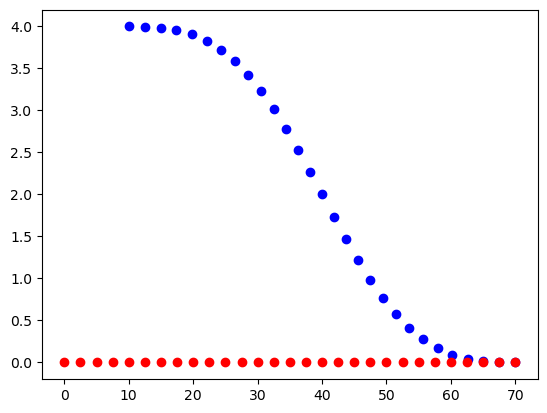

In [56]:
evaluate_PTG(
    start_s=[10, 10, 0],
    start_d=[4, 0, 0],
    target_vehicle=0,
    delta=[0, 0, 0, 0, 0, 0],
    T=5,
    predictions={0: Vehicle([0, 10, 0, 0, 0, 0])}
)

In the above result, we see exactly what we were expecting — a final ego-vehicle state (in blue) matching exactly the other vehicle (in blue). And, to no surprise, the ego-vehicle collided with the other vehicle in order to meet this demand.

##### Experiment 3: Manually configuring the weights

Now, let's shake things up a bit. We'll keep roughly the same goal state as before, i.e., match the other vehicle's final state, but instead modify `delta` to put our ego-vehicle `-10` metres behind the other vehicle. Then, let's reconfigure the `collision_cost` weight back to a value of `1.0`. This way, we'll try to find a manoeuvre that avoids a collision and keeps a respectable distance from the other vehicle. However, this comes with some cost — we'll be sacrificing here our expectations regarding the time and exact position we've set for our ego-vehicle to end up at. We'll also be weighing the `efficiency_cost` and comfort costs (`total_accel_cost`, `total_jerk_cost`) a bit less in order to make this trajectory possible.

In [101]:
WEIGHTED_COST_FUNCTIONS = [
    (time_diff_cost,    0.7),
    (s_diff_cost,       0.8),
    (d_diff_cost,       0.75),
    (efficiency_cost,   0.5),
    (max_jerk_cost,     1),
    (total_jerk_cost,   0.8),
    # Here we set collision cost weight value to zero (i.e., no contribution)
    (collision_cost,    1),
    (buffer_cost,       1),
    (max_accel_cost,    1),
    (total_accel_cost,  0.8),
]

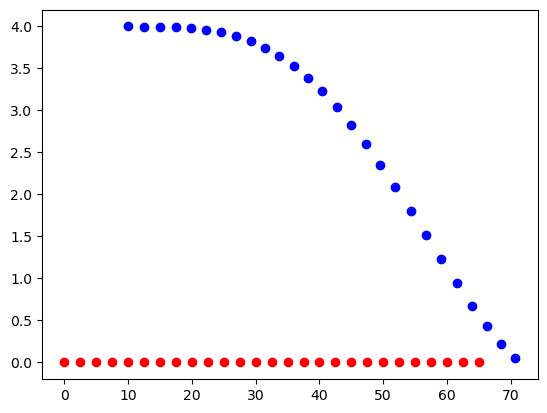

In [102]:
evaluate_PTG(
    start_s=[10, 10, 0],
    start_d=[4, 0, 0],
    target_vehicle=0,
    delta=[-10, 0, 0, 0, 0, 0],
    T=5,
    predictions={0: Vehicle([0, 10, 0, 0, 0, 0])}
)

From the above experiment run we see that the vehicle arrived at a goal position matching the other vehicle in just the lateral direction; in the longitudinal direction our ego-vehicle is slightly in front of the other vehicle. While this trajectory did not result in a collision, the acceleration in the longitudinal direction, $\ddot{s}$, seems to be quite high during the manoeuvre of the lane change (as indicated by the farther spread out 'dots' — a bigger displacement per time-step is apparent). 

The results of this experiment reflect the trade-offs we made while selecting the cost function weight values.

#### In Summary

From the experiments above we observed the effect of cost function weight values on the trajectory planner. When equal weight is given to the cost function values, we are able to safely execute a trajectory that puts our ego-vehicle at the intended goal (unless a collision is imminent or the manoeuvre is not feasible). When we adjust the weight values for, say, collision avoidance, we see the trajectory planner selecting a route that, to no surprise, results in a collision.

This demonstrates the importance of designing robust cost functions that prioritise feasibility, safety, comfort, and efficiency.

## 3. Closing Remarks
##### Alternatives
* Replicate other driving scenarios to repeat the simulation with (e.g., vehicle to take over the lane of speeds up, preventing the lane change and leading to a potentially aggressive / dangerous ego-vehicle manoeuvre);
* Adjust the weight values in consideration of other goals (e.g., prioritise not exceeding max speed).

##### Extensions of task
* Finish the `stays_on_road_cost` and `exceeds_speed_limit_cost` functions;
* Add additional traffic to the highway scene (i.e., simulate additional vehicle actors / lanes);
* Create additional cost functions not mentioned here.

## 4. Future Work

* ⬜️ Finish the `stays_on_road_cost` and `exceeds_speed_limit_cost` functions;
* ⬜️ Experiment with different cost function weight configurations;
* ⬜️ Add additional traffic to the scene.

## Credits

This assignment was prepared by Sebastian Thrun and Emmanuel Boidot of Mercedes-Benz R&D, Winter 2021 (link [here](https://www.udacity.com/course/self-driving-car-engineer-nanodegree--nd0013)).